In [ ]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the parquet file
train_df = pq.read_table("/content/drive/MyDrive/collabnotebooks/train.parquet").to_pandas()

In [ ]:
# Filter only the "TARGET DRUG" incidents
train_df = train_df[train_df["Incident"] == "TARGET DRUG"]

In [ ]:
# Group the data by "Patient-Uid" and calculate the time difference between each administration
train_df = train_df.sort_values(['Patient-Uid','Date'])
train_df['diff'] = (train_df.groupby('Patient-Uid')['Date'].diff() / np.timedelta64(1, 'M'))
train_df['diff'] = train_df['diff'].fillna(0)

In [ ]:
# Group the data by "Patient-Uid" and calculate the mean time difference in months
mean_months = train_df.groupby("Patient-Uid")["diff"].mean().reset_index()
mean_months.rename({"diff":"mean_months"},axis=1,inplace=True)

In [ ]:
# Use KMeans to cluster the data based on the mean time difference in months
kmeans = KMeans(n_clusters=3)
kmeans.fit(mean_months[["mean_months"]])
mean_months["cluster"] = kmeans.predict(mean_months[["mean_months"]])

In [ ]:
mean_months

,Patient-Uid,mean_months,cluster
0,a0e9c384-1c7c-11ec-81a0-16262ee38c7f,0.613291,2
1,a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f,1.651705,0
2,a0e9c3e3-1c7c-11ec-a8b9-16262ee38c7f,1.708454,0
3,a0e9c414-1c7c-11ec-889a-16262ee38c7f,1.631793,0
4,a0e9c443-1c7c-11ec-9eb0-16262ee38c7f,1.264913,0
...,...,...,...
9369,a0f0d4c5-1c7c-11ec-bfec-16262ee38c7f,0.821372,2
9370,a0f0d4f4-1c7c-11ec-b144-16262ee38c7f,0.000000,2
9371,a0f0d523-1c7c-11ec-89d2-16262ee38c7f,0.898033,2
9372,a0f0d553-1c7c-11ec-a70a-16262ee38c7f,0.000000,2


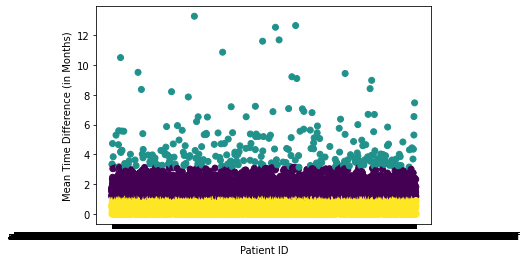

In [ ]:
# Plot the clusters using matplotlib
plt.scatter(mean_months["Patient-Uid"], mean_months["mean_months"], c=mean_months["cluster"], cmap='viridis')
plt.xlabel("Patient ID")
plt.ylabel("Mean Time Difference (in Months)")
plt.show()

KeyboardInterrupt: ignored

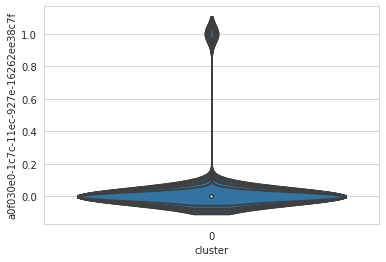

In [ ]:
import seaborn as sns

for cluster in mean_months['cluster'].unique():
    cluster_df = train_df[train_df['Patient-Uid'].isin(mean_months[mean_months['cluster'] == cluster]['Patient-Uid'].tolist())]
    pivot_table = pd.pivot_table(cluster_df, values='Incident', index='Date', columns='Patient-Uid', aggfunc='count', fill_value=0)
    pivot_table['cluster'] = cluster

    for column in pivot_table.columns[:-1]:
        sns.violinplot(x='cluster', y=column, data=pivot_table)

plt.xlabel("Cluster")
plt.ylabel("Number of Prescriptions")
plt.show()
